# 1. *Retention*

Retention – один из самых важных показателей в компании. Ваша задача – написать функцию, которая будет считать retention игроков (по дням от даты регистрации игрока). 

Данные следующую структуру:

* shared/problem1-reg_data.csv – данные о времени регистрации

|   auth_ts | uid |
|-----------|-----|
| 906166566 |   2 |
| 906344325 |   2 |
| 906686169 |   2 |
| 906893386 |   2 |
| 906980227 |   2 |

* shared/problem1-auth_data.csv – данные о времени захода пользователей в игру


|    reg_ts | uid |
|-----------|-----|
| 906166566 |   2 |
| 924422172 |   3 |
| 937374732 |   4 |
| 947425117 |   5 |
| 955630339 |   6 |

Функция должна быть написана на python. В ходе решения можно тестировать работу функции как на полном датасете, так и на части (сэмпле) данных.


In [3]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

In [4]:
reg_data = pd.read_csv('/home/jupyter-a.shashlov-12/shared/problem1-reg_data.csv', sep=';')

In [5]:
auth_data = pd.read_csv('/home/jupyter-a.shashlov-12/shared/problem1-auth_data.csv', sep=';')

In [6]:
reg_data.head(3)

,reg_ts,uid
0,911382223,1
1,932683089,2
2,947802447,3


In [7]:
auth_data.head(3)

,auth_ts,uid
0,911382223,1
1,932683089,2
2,932921206,2


In [8]:
reg_data.shape

(1000000, 2)

In [9]:
auth_data.shape

(9601013, 2)

In [10]:
df = pd.merge(reg_data, auth_data, how='left', on=['uid'])

In [11]:
df.head()

,reg_ts,uid,auth_ts
0,911382223,1,911382223
1,932683089,2,932683089
2,932683089,2,932921206
3,932683089,2,933393015
4,932683089,2,933875379


In [12]:
df.shape

(9601013, 3)

In [13]:
def retention(data, start_date, end_date, periods, cohort_type='monthly_cohorts', cohort_intervals='month'):
    '''
    Функция для подсчета retention
    
        Параметры:
            data: Датафрейм с данными, где
                auth_ts - Дата авторизации в приложении в формате timestamp
                reg_ts - Дата регистрации в приложении в формате timestamp
            start_date: Начало периода
            end_date: Конец периода
            cohort_type: Тип когорты(по дням/неделям/месяцам)
            cohort_intervals: Интервалы(дни/недели/месяцы)
        
        Возвращает таблицу с retention для выбраного типа когорты и интервала
             
    '''
    
    data.auth_ts = pd.to_datetime(data.auth_ts, unit='s')
    data.reg_ts = pd.to_datetime(data.reg_ts, unit='s') 
    
    if cohort_intervals == 'month':
        data['month'] = (data.auth_ts - data.reg_ts).div(np.timedelta64(1, 'M')).astype(int)        
    elif cohort_intervals == 'week':
        data['week'] = (data.auth_ts - data.reg_ts).dt.days.div(7).astype(int)         
    elif cohort_intervals == 'day':
        data['day'] = (data.auth_ts - data.reg_ts).dt.days
     
    if cohort_type == 'monthly_cohorts':
        data['monthly_cohorts'] = data.reg_ts.dt.to_period('M')
    elif cohort_type == 'weekly_cohorts':     
        data['weekly_cohorts'] = data.reg_ts.dt.to_period('W')
    elif cohort_type == 'dayly_cohorts':
        data['dayly_cohorts'] = data.reg_ts.dt.to_period('d')
    
    grouped = data.query('reg_ts >=  @start_date &  reg_ts <= @end_date ')\
                  .groupby([cohort_type, cohort_intervals], as_index=False)\
                  .agg({'uid': 'nunique'})
    
    t_pivot = grouped.pivot(index=cohort_type, columns=cohort_intervals, values='uid')
    t_pivot = t_pivot[periods]
    return round(t_pivot.div(t_pivot[0].values, axis=0), 3)

In [22]:
 def retention_heatmap(table):

    plt.figure(figsize=(20, table.shape[0]//1.5))
    plt.title('Retention by '+ table.columns.name)
    ax = sns.heatmap(data=table, annot=True, fmt='.0%', cbar=False, square=True, cmap='YlGnBu')
    
    ax.xaxis.tick_top()
    ax.set_xlabel('')
    ax.set_ylabel(table.index.name)
    plt.yticks(rotation=0)    
    plt.show()

In [23]:
t = retention(df, '2019-01-01', '2021-01-01',
              cohort_type='monthly_cohorts', 
              cohort_intervals='week',
              periods=[0, 1, 2, 3, 4, 5, 6, 7])

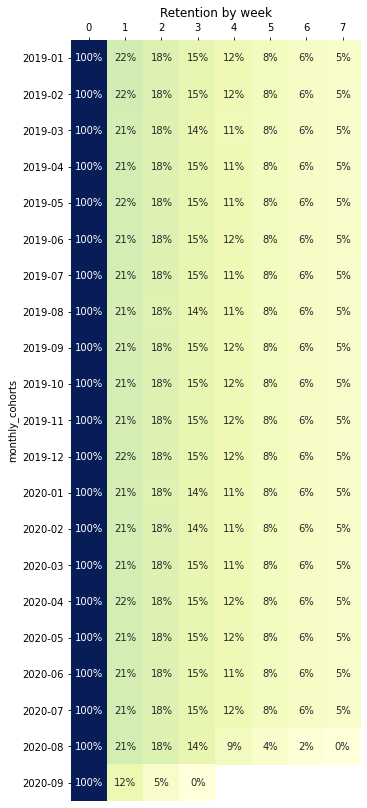

In [24]:
retention_heatmap(t)